### Задача:
Подготовить в Google Colaboratory с использованием библиотек (Keras/Tensorflow, NumPy, Pandas, Matplotlib) пример обучения любой сверточной нейронной сети, на любом учебном датасете. Показать в примере навыки работы с выборками, провести аугментацию данных, визуализировать процесс обучения.

---

Сверточные нейронные сети используются в обработке изображений и видео, для классификации и распознования объектов. В этой работе бдует реализована `классификация рукописых цифр` из учебного датасета `MNIST`.

In [ ]:
# Для начала импортируем необходимые библиотеки для работы с программой
import numpy as np # для работы с данными
import pandas as pd # для таблиц
import matplotlib.pyplot as plt # для отрисовки графиков

# from tensorflow.keras import utils # позволяет использоавть утилиты keras в tf
from tensorflow.keras.datasets import mnist # набор данных mnist
from sklearn.model_selection import train_test_split # для разделения данных
from tensorflow.keras.models import Sequential # для последоватлеьного создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization # для создания слоев
from tensorflow.keras.preprocessing import image # для преобразования изобажений в тензоры
from tensorflow.keras.preprocessing.image import ImageDataGenerator # для аугментации
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint # обратные вызовы
from tensorflow.keras import utils

# для отображения графиков непосредственно в выводе ячейки
%matplotlib inline

# Предобработка и загрузка данных

In [ ]:
# загружаем датасет и получаем обучающие и тетсовые данные
(x_train, y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = np.expand_dims(x_train, axis=3) # добавляем измерение, которое обозначает, что у данных один канал (оттенки серого)
y_train = utils.to_categorical(y_train) # преобразуемданные меток в формат one hot encoding
X_test = np.expand_dims(X_test, axis=3)
Y_test = utils.to_categorical(Y_test)

In [ ]:
# кол-во изображений \ размер изоюражеиня \ кол-во каналов
# кол-во меток \ кол-во классов
print(f'X_train: {x_train.shape}\nY_train: {y_train.shape}\n')

print(f'X_test: {X_test.shape}\nY_test: {Y_test.shape}\n')

X_train: (60000, 28, 28, 1)
Y_train: (60000, 10)

X_test: (10000, 28, 28, 1)
Y_test: (10000, 10)



In [ ]:
# чтобы данные не разделялись постоянно на новые выборки ставим сид
random_seed = 0
# создаем новую проверочную выборку. Из обучающих данных для проверочных отцепляем кусок в 10 процентов
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [ ]:
print(f'X_train: {X_train.shape}\nY_train: {Y_train.shape}\n')

print(f'X_val: {X_val.shape}\nY_val: {Y_val.shape}\n')

print(f'X_test: {X_test.shape}\nY_test: {Y_test.shape}\n')

X_train: (54000, 28, 28, 1)
Y_train: (54000, 10)

X_val: (6000, 28, 28, 1)
Y_val: (6000, 10)

X_test: (10000, 28, 28, 1)
Y_test: (10000, 10)



# Визуализируем данные

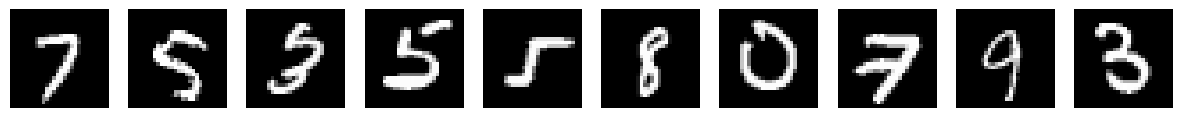

In [ ]:
plt.figure(figsize=(15, 2)) # размер полотна

# выведем 10 примеров изображений из обучающей выборки
for i in range(10):
    # полотно 1 в высоту, 10 в ширину, после, каждая ячейка заполняется по циклу
    plt.subplot(1, 10, i+1)
    # в каждую ячейку закидываем новую картинку из обучающей выборки
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')

# Создадим генератор, для расширения данных во время обучения

In [ ]:
datagen = ImageDataGenerator(rotation_range = 10, # случайное вращение
                             zoom_range = 0.2, # случайное масштабироавниее
                             width_shift_range=0.2, # случайное вытяигвание в ширину
                             height_shift_range=0.2) # в высоту

скопируем одну картинку из обучающего набора, чтобы посмотреть как работает генератор

In [ ]:
data = X_train[1]

In [ ]:
print(f'shape data (X_train[1]): {data.shape}')

shape data (X_train[1]): (28, 28, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

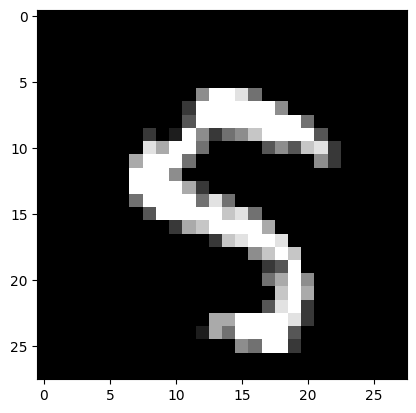

In [ ]:
# изображение до манипуляций генератора
plt.imshow(data, cmap='gray')
plt.show

In [ ]:
# добавим ось на первую позицию для отображения количества изображений
data = np.expand_dims(data, axis=0)

In [ ]:
print(f'shape data (X_train[1]): {data.shape}')

shape data (X_train[1]): (1, 28, 28, 1)


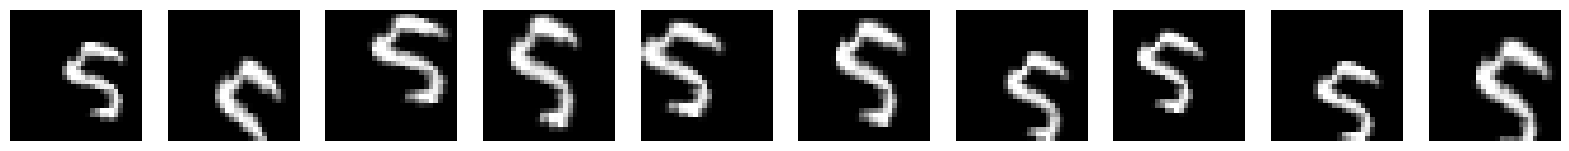

In [ ]:
i = 0
plt.figure(figsize=(20, 2))

# batch_size - указывает количество изображений, которые будут созданы в каждом батче
for batch in datagen.flow(data, batch_size = 1):
    plt.subplot(1, 10, i+1)
    plt.imshow(batch[0][:, :], cmap='gray')
    plt.axis('off')

    i += 1
    if i == 10:
        break

# Создаем нейронную сеть

In [ ]:
model = Sequential() # для создания линейного набора слоев модели

# Conv2D для добавления к модели 2D-сверточного слоя
model.add(Conv2D(filters = 64, # кол-во фильтров
                 kernel_size = (5, 5), # размер фильтров
                 padding = 'Same', # Same заполнение для предотвращения потери информации по краям изображения
                 activation = 'relu', # функция активации, позволяет проходить через слой только положительным значениям
                 input_shape = (28, 28, 1))) # форма входных данных
model.add(BatchNormalization()) # для нормализации входных данных
model.add(MaxPooling2D(pool_size = (2, 2))) # для понижения разрешения путем взятия максимального значения в pool_size
model.add(Dropout(0.25)) # исключаем кусок для предотвращения переобучения

model.add(Conv2D(filters = 128,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# полносвязная часть, отвечает за классификацию
model.add(Flatten()) # для изменения данных слоя MaxPooling2D в одномерный массив
# добовляем полносвязный слой
model.add(Dense(256, # кол-во нейронов
                activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, # 10 нейронов на выход, т.к. в наборе данных 10 классов
                activation = "softmax")) # чтобы в выводе были вероятности принадлежности к определенному классу

In [ ]:
# функция потерь - categorical_crossentropy т.к. несоклько классов
# оптимизатор - для обновления весов
# метрика - для указания показателей оценки, accuracy измеряет долю правильно классифицированных образцов
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       5

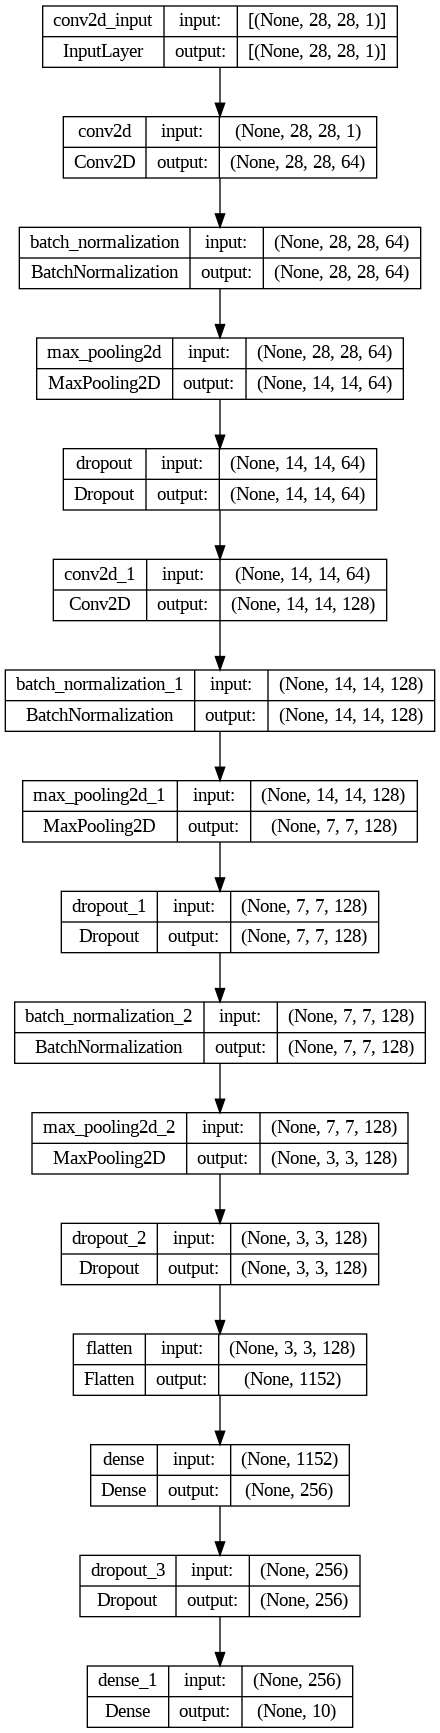

In [ ]:
utils.plot_model(model, show_shapes = True, show_layer_names=True)

# Обучаем нейронную сеть

In [ ]:
# для сохранения данных модели
checkpoint = ModelCheckpoint('mnist-cnn.h5',
                             monitor = 'val_accuracy', # метрика, которую будем отслеживать
                             save_best_only=True, # сохраняем только улучшения
                             verbose = 1) # для отображения выполнения

# для снижения скорости обучения
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2, # эпохи без улучшений
                                            verbose = 1,
                                            factor = 0.5, # уменьшение скорости обучения в 0,5 раз
                                            min_lr = 0.00001) # минимальная скорость обучения

In [ ]:
batch_size = 100
epochs = 50

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size = batch_size), # для создания пакетов дополненных изображений
                    epochs = epochs,
                    validation_data = (X_val, Y_val), # данных проверки, которые будут использоваться во время обучения
                    steps_per_epoch = X_train.shape[0]//batch_size, # шаг за эпоху
                    verbose = 1,
                    callbacks = [checkpoint, learning_rate_reduction]) # обратные вызовы

Epoch 1/50
539/540 [============================>.] - ETA: 0s - loss: 0.7087 - accuracy: 0.7724
Epoch 1: val_accuracy improved from -inf to 0.97333, saving model to mnist-cnn.h5
540/540 [==============================] - 34s 38ms/step - loss: 0.7081 - accuracy: 0.7726 - val_loss: 0.0852 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 2/50
  1/540 [..............................] - ETA: 43s - loss: 0.3206 - accuracy: 0.9100

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


539/540 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9257
Epoch 2: val_accuracy improved from 0.97333 to 0.98650, saving model to mnist-cnn.h5
540/540 [==============================] - 19s 36ms/step - loss: 0.2490 - accuracy: 0.9256 - val_loss: 0.0508 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 3/50
539/540 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9443
Epoch 3: val_accuracy did not improve from 0.98650
540/540 [==============================] - 21s 38ms/step - loss: 0.1880 - accuracy: 0.9443 - val_loss: 0.0725 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 4/50
539/540 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9517
Epoch 4: val_accuracy improved from 0.98650 to 0.98783, saving model to mnist-cnn.h5
540/540 [==============================] - 21s 38ms/step - loss: 0.1615 - accuracy: 0.9518 - val_loss: 0.0382 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 5/50
540/540 [==============================] - ETA: 0s - 

In [ ]:
# загружаем информацию об обученой модели
model.load_weights('mnist-cnn.h5')

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
# выводим инфоррмацию о модели
history_df = pd.DataFrame()

for key in history.history.keys():
    history_df[key] = history.history[key]
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.708115,0.772556,0.085201,0.973333,0.001000
1,0.248971,0.925630,0.050791,0.986500,0.001000
2,0.187998,0.944315,0.072514,0.980500,0.001000
3,0.161513,0.951759,0.038209,0.987833,0.001000
4,0.142747,0.958981,0.044495,0.987500,0.001000
5,0.131721,0.962093,0.040944,0.988167,0.001000
6,0.125712,0.963444,0.037558,0.989000,0.001000
7,0.114387,0.966241,0.036547,0.990500,0.001000
8,0.110121,0.968463,0.034056,0.989500,0.001000
9,0.103012,0.969926,0.032296,0.990833,0.001000


In [ ]:
max(history.history['val_accuracy'])

0.9955000281333923

# Визуализируем качество обучения

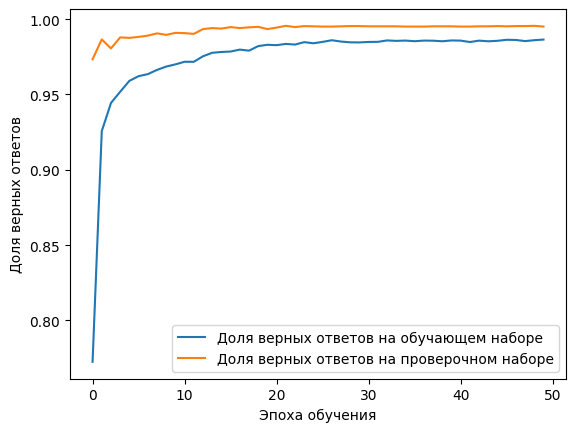

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Проверяем модель на тестовых данных

In [ ]:
# предсказываем
predictions = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [ ]:
# первые 3 примера из тестовой выбрки, где результаты - проценты принадлежности к каждому классу
predictions[:3]

array([[2.1487062e-15, 1.3434047e-09, 4.3784687e-09, 2.1002143e-10,
        7.6721637e-13, 1.3724867e-14, 1.8074668e-23, 1.0000000e+00,
        1.5137730e-13, 4.7407389e-10],
       [4.1103831e-09, 4.5134039e-11, 1.0000000e+00, 3.7560337e-09,
        8.3627671e-14, 4.2526112e-14, 6.1720984e-13, 2.8006597e-09,
        1.2870029e-10, 1.3009218e-11],
       [6.8711239e-12, 1.0000000e+00, 7.1933921e-09, 4.0748400e-14,
        1.3620302e-09, 1.3950766e-10, 3.9856015e-08, 5.4227987e-09,
        2.7258457e-08, 1.1562277e-11]], dtype=float32)

In [ ]:
# преобразуем результаты распознавания из формата one hot encoding в цифры
predictions = np.argmax(predictions, axis=1)

In [ ]:
predictions[:3]

array([7, 2, 1])

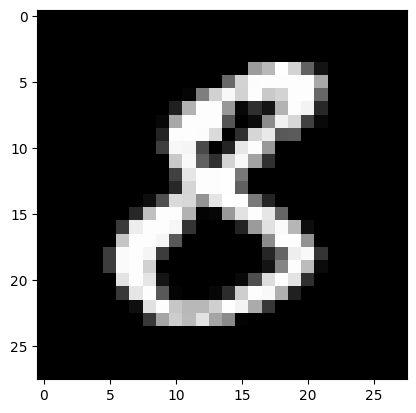

Ответ модели: 8


In [ ]:
n = 1234 # номре экземпляра X_test выборки

# рисуем картинку
plt.imshow(X_test[n].reshape(28, 28, 1), cmap = 'gray')
plt.show()

# ответ который предсказала модель
print(f'Ответ модели: {predictions[n]}') #